<a href="https://colab.research.google.com/github/guilhermecgs/apdoac/blob/master/apdoac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dados da tese de mestrado APDOAC

In [1]:
!npx degit guilhermecgs/apdoac/dados -f

npx: installed 1 in 2.234s
> destination directory is not empty. Using --force, continuing
> cloned guilhermecgs/apdoac#master


In [13]:
! pip install pandas
! pip install tqdm
! pip install xlsx2csv
! pip install genderbr
! pip install --upgrade genderbr

  Created wheel for genderbr: filename=genderbr-0.1.2-cp36-none-any.whl size=2268 sha256=c3c3f7680c1ba0500eecfc0c83e3aa3c682ba2af1d5dc41a350d26e45f4e6f4f
  Stored in directory: /root/.cache/pip/wheels/40/72/3c/16afd51aa7b8d98204f781c2854ff8b37623665e6e9fcc20f6
Successfully built genderbr
  Found existing installation: genderbr 0.1.1
    Uninstalling genderbr-0.1.1:
      Successfully uninstalled genderbr-0.1.1


In [4]:
import pandas as pd
from tqdm.notebook import trange, tqdm


In [5]:
df_cnpq_2002_2019 = pd.read_excel('cnpq_2002-2019_pq.xlsx')

def primeiro_nome(nome):
  return nome.split(' ')[0]

df_cnpq_2002_2019['primeiro_nome'] = df_cnpq_2002_2019['Beneficiário'].apply(lambda nome: primeiro_nome(nome))

primeiros_nomes_unicos = df_cnpq_2002_2019['primeiro_nome'].unique()

from genderbr import get_gender

result = {}
for primeiro_nome in tqdm(primeiros_nomes_unicos):
  result[primeiro_nome] = str(get_gender(primeiro_nome))
  print(primeiro_nome + result[primeiro_nome])

df_cnpq_2002_2019['sexo'] = df_cnpq_2002_2019['primeiro_nome'].apply(lambda primeiro_nome: result[primeiro_nome])

df_cnpq_2002_2019.to_excel('cnpq_2002-2019_pq_com_sexo.xlsx')


AbdelhakNone
AbdênagoNone
AbelM
AbelardoM
AbelmonNone
AbilioM
AbimaelM
AbnerM
AbraãoM
AbrahamM
AbrahãoM
AbramoM
AcaciaF
AcácioM
AcelinoM
AchillesM
AcrisioM
AcyleneNone
AdaF
AdaildoM
AdailtonM
AdairM
AdalbertoM
AdaleneF
AdalgisaF
AdalgizaF
AdalieneNone
AdalmirM
AdaltoM
AdaltonM
AdamoM
AdánM
AdaoM
AdautoM
AdeildoM
AdeiltonM
AdejardoNone
AdelarM
AdeleF
AdeliaF
AdelinaF
AdelinoM
AdelirM
AdelmirM
AdemarM
AdemirM
AdeneyNone
AdenildaF
AdenilsoM
AdenilsonM
AdeniltonM
AdenirM
AdeniseF
AderbalM
AdersonM
AdervalM
AdésioM
AdhemarM
AdibeM
AdielM
AdilmoM
AdilsonM
AdimirM
AdivaldoM
AdjaF
AdleyM
AdmaF
AdoM
AdolfoM
AdolphoM
AdoneM
AdônisM
AdrianM
AdrianaF
AdrianeF
AdrianoM
AdrianusNone
AdriãoM
AdrielM
AdroaldoM
AdryaneF
AdsonM
AduniasNone
AffonsoM
AfonsoM
AfranioM
AfrânioM
AgataF
AgenorM
AgmaF
AgnaldoM
AgnesF
AgnieszkaNone
AguedaF
AguinaldoM
AhdaNone
AhmadM
AidaF
AikeM
AiltonM
AirtonM
AjalmarNone
AjaxM
AkemiF
AlacoqueNone
AlagaconeNone
AlaideF
AlainM
AlamM
AlamirM
AlanM
AlanaF
AlaneF
AlaorM
AlbaF
Alber

Descobrindo o sexo dos bolsistas cnpq

In [ ]:
import os
import glob
from tqdm.notebook import trange, tqdm
from xlsx2csv import Xlsx2csv
  

def concat(pathname):
  arquivos = glob.glob(pathname)
  print('Unindo arquivos:')
  print('\n    -'.join(arquivos))

  dfs = []
  for arquivo in tqdm(arquivos):
    arquivo_csv = arquivo.replace('xlsx', 'csv')
    if not os.path.isfile(arquivo_csv):
      Xlsx2csv(arquivo, outputencoding="utf-8").convert(arquivo.replace('xlsx', 'csv'))

    dfs.append(pd.read_csv(arquivo_csv))
    
  return pd.concat(dfs)


In [ ]:
df_discentes = concat('discente/*.xlsx')



Unindo arquivos:
discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2014.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2016.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2015.xlsx
    -discente/br-capes-colsucup-discentes-2013a2016-2020-06-12_2013.xlsx


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
print(len(df_discentes[(df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'ENGENHARIAS') 
                        & (df_discentes['AN_BASE'] == 2016)
                        & (df_discentes['TP_SEXO_DISCENTE'] == 'FEMININO')
                        ].index))


15129


In [ ]:
df_discentes.head(3)

,AN_BASE,NM_GRANDE_AREA_CONHECIMENTO,CD_AREA_AVALIACAO,NM_AREA_AVALIACAO,CD_ENTIDADE_CAPES,CD_ENTIDADE_EMEC,SG_ENTIDADE_ENSINO,NM_ENTIDADE_ENSINO,CS_STATUS_JURIDICO,DS_DEPENDENCIA_ADMINISTRATIVA,NM_MODALIDADE_PROGRAMA,NM_GRAU_PROGRAMA,CD_PROGRAMA_IES,NM_PROGRAMA_IES,NM_REGIAO,SG_UF_PROGRAMA,NM_MUNICIPIO_PROGRAMA_IES,CD_CONCEITO_PROGRAMA,CD_CONCEITO_CURSO,ID_PESSOA,TP_DOCUMENTO_DISCENTE,NR_DOCUMENTO_DISCENTE,NM_DISCENTE,NM_PAIS_NACIONALIDADE_DISCENTE,DS_TIPO_NACIONALIDADE_DISCENTE,TP_SEXO_DISCENTE,AN_NASCIMENTO_DISCENTE,DS_FAIXA_ETARIA,DS_GRAU_ACADEMICO_DISCENTE,ST_INGRESSANTE,NM_SITUACAO_DISCENTE,DT_MATRICULA_DISCENTE,DT_SITUACAO_DISCENTE,QT_MES_TITULACAO,NM_TESE_DISSERTACAO,NM_ORIENTADOR,ID_ADD_FOTO_PROGRAMA,ID_ADD_FOTO_PROGRAMA_IES
0,2014,CIÊNCIAS BIOLÓGICAS,9,CIÊNCIAS BIOLÓGICAS III,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,MESTRADO/DOUTORADO,10001018002P1,BIOLOGIA EXPERIMENTAL,NORTE,RO,PORTO VELHO,3,3,834339,CPF,***.528.062-**,ANDONAI KRAUZE DE FRANCA,BRASIL,BRASILEIRO,MASCULINO,1977,35 A 39 ANOS,DOUTORADO,SIM,MATRICULADO,07MAY2014:00:00:00,07MAY2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,52358,115724
1,2014,MULTIDISCIPLINAR,49,CIÊNCIAS AMBIENTAIS,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,MESTRADO,10001018017P9,CIÊNCIAS AMBIENTAIS,NORTE,RO,ROLIM DE MOURA,3,3,1460252,CPF,***.492.512-**,RICHELLY GISELA PASQUALOTTO TEIXEIRA,BRASIL,BRASILEIRO,FEMININO,1991,20 A 24 ANOS,MESTRADO,SIM,MATRICULADO,18AUG2014:00:00:00,18AUG2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,51138,114408
2,2014,MULTIDISCIPLINAR,48,BIOTECNOLOGIA,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,FEDERAL,PÚBLICA,ACADÊMICO,DOUTORADO,12001015038P1,BIODIVERSIDADE E BIOTECNOLOGIA - REDE BIONORTE,NORTE,RO,PORTO VELHO,4,4,437724,CPF,***.757.282-**,LEIDIANE CAROLINE LAUTHARTTE,BRASIL,BRASILEIRO,FEMININO,1987,25 A 29 ANOS,DOUTORADO,SIM,MATRICULADO,03MAR2014:00:00:00,03MAR2014:00:00:00,0,NÃO SE APLICA,NÃO SE APLICA,49200,112306


Plotando número de mulheres com bolsas de mestrado na area de exatas

In [ ]:

df_discentes.groupby('NM_GRAU_PROGRAMA').NM_GRAU_PROGRAMA.count()


NM_GRAU_PROGRAMA
DOUTORADO                 18634
MESTRADO                 194756
MESTRADO PROFISSIONAL    147525
MESTRADO/DOUTORADO       952529
Name: NM_GRAU_PROGRAMA, dtype: int64

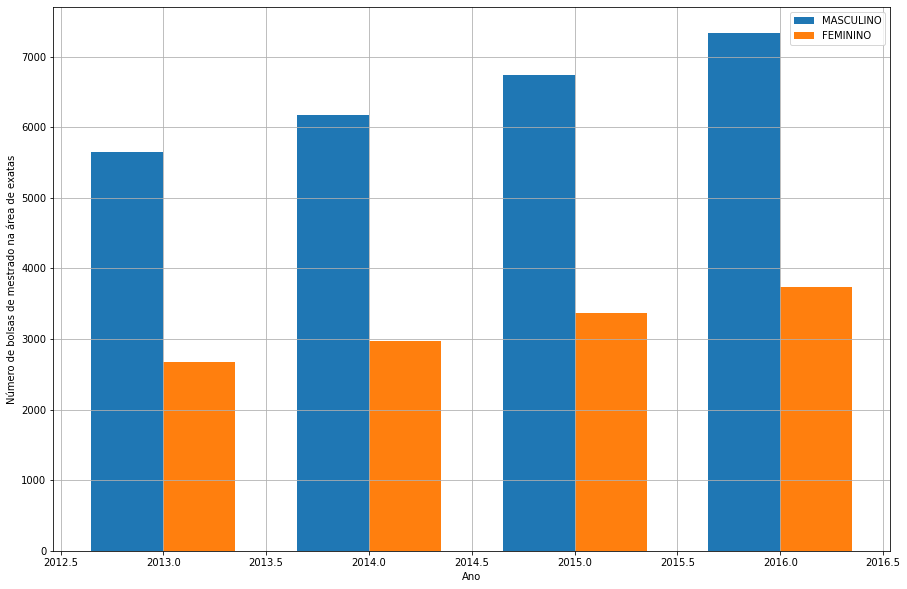

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15, 10))

width = 0.35
sexos = ['MASCULINO', 'FEMININO']

for sexo in sexos:
  df = df_discentes[((df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'ENGENHARIAS')  
                     | (df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'CIÊNCIAS EXATAS E DA TERRA')) 
                     & (df_discentes['TP_SEXO_DISCENTE'] == sexo)
                     & (df_discentes['NM_GRAU_PROGRAMA'] == 'MESTRADO')]
  
  
  series = df.groupby('AN_BASE').AN_BASE.count()
  if sexo == 'MASCULINO':
    ax.bar(series.index - width/2, series, width,  label=sexo)
  else:
    ax.bar(series.index + width/2, series, width,  label=sexo)

#df

ax.grid(True)
ax.set_xlabel("Ano")
ax.set_ylabel("Número de bolsas de mestrado na área de exatas")
ax.legend(loc='best')



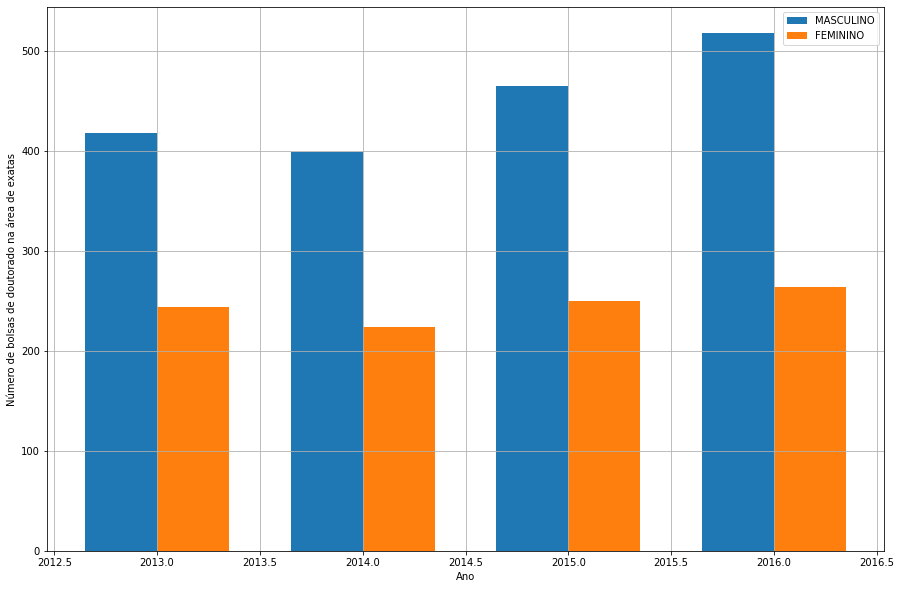

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15, 10))

width = 0.35
sexos = ['MASCULINO', 'FEMININO']

for sexo in sexos:
  df = df_discentes[((df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'ENGENHARIAS')  
                     | (df_discentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'CIÊNCIAS EXATAS E DA TERRA')) 
                     & (df_discentes['TP_SEXO_DISCENTE'] == sexo)
                     & (df_discentes['NM_GRAU_PROGRAMA'] == 'DOUTORADO')]
  
  
  series = df.groupby('AN_BASE').AN_BASE.count()
  if sexo == 'MASCULINO':
    ax.bar(series.index - width/2, series, width,  label=sexo)
  else:
    ax.bar(series.index + width/2, series, width,  label=sexo)

#df

ax.grid(True)
ax.set_xlabel("Ano")
ax.set_ylabel("Número de bolsas de doutorado na área de exatas")
ax.legend(loc='best')



In [ ]:
df_docentes = concat('docente/*.xlsx')

Unindo arquivos:
docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2013.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2014.xlsx
    -docente/br-capes-colsucup-docente-2018-2020-06-12.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2015.xlsx
    -docente/br-capes-colsucup-curso-2017-2020-06-12.xlsx
    -docente/br-capes-colsucup-docente-2013a2016-2020-06-12_2016.xlsx


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
df_docentes

,AN_BASE,CD_AREA_AVALIACAO,NM_AREA_AVALIACAO,NM_GRANDE_AREA_CONHECIMENTO,NM_AREA_CONHECIMENTO,CD_PROGRAMA_IES,NM_PROGRAMA_IES,NM_GRAU_PROGRAMA,NM_MODALIDADE_PROGRAMA,CD_CONCEITO_PROGRAMA,CD_ENTIDADE_CAPES,CD_ENTIDADE_EMEC,SG_ENTIDADE_ENSINO,NM_ENTIDADE_ENSINO,DS_DEPENDENCIA_ADMINISTRATIVA,CS_STATUS_JURIDICO,NM_MUNICIPIO_PROGRAMA_IES,SG_UF_PROGRAMA,NM_REGIAO,ID_PESSOA,TP_DOCUMENTO_DOCENTE,NR_DOCUMENTO_DOCENTE,NM_DOCENTE,TP_SEXO_DOCENTE,AN_NASCIMENTO_DOCENTE,DS_FAIXA_ETARIA,DS_TIPO_NACIONALIDADE_DOCENTE,NM_PAIS_NACIONALIDADE_DOCENTE,DS_CATEGORIA_DOCENTE,DS_TIPO_VINCULO_DOCENTE_IES,DS_REGIME_TRABALHO,CD_CAT_BOLSA_PRODUTIVIDADE,IN_DOUTOR,AN_TITULACAO,NM_GRAU_TITULACAO,CD_AREA_BASICA_TITULACAO,NM_AREA_BASICA_TITULACAO,SG_IES_TITULACAO,NM_IES_TITULACAO,NM_PAIS_IES_TITULACAO,ID_ADD_FOTO_PROGRAMA,ID_ADD_FOTO_PROGRAMA_IES,DS_CLIENTELA_QUADRIENAL_2017,NM_SUBAREA_CONHECIMENTO,NM_ESPECIALIDADE,DS_ORGANIZACAO_ACADEMICA,CD_CURSO_PPG,NM_CURSO,NM_GRAU_CURSO,CD_CONCEITO_CURSO,AN_INICIO_PREVISTO,DS_SITUACAO_CURSO,DT_SITUACAO_CURSO
0,2013,9,CIÊNCIAS BIOLÓGICAS III,CIÊNCIAS BIOLÓGICAS,PARASITOLOGIA,10001018002P1,BIOLOGIA EXPERIMENTAL,MESTRADO/DOUTORADO,ACADÊMICO,3,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,PÚBLICA,FEDERAL,PORTO VELHO,RO,NORTE,832956.0,CPF,***.482.422-**,NAJLA BENEVIDES MATOS,FEMININO,1975.0,35 A 39 ANOS,BRASILEIRO,BRASIL,COLABORADOR,COLABORADOR,PARCIAL,NaN,S,2008.0,DOUTORADO,21200009.0,MICROBIOLOGIA,PARIS 7,UNIVERSITÉ PARIS DIDEROT - PARIS VII,FRANÇA,52357,115723,AVALIAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,9,CIÊNCIAS BIOLÓGICAS III,CIÊNCIAS BIOLÓGICAS,PARASITOLOGIA,10001018002P1,BIOLOGIA EXPERIMENTAL,MESTRADO/DOUTORADO,ACADÊMICO,3,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,PÚBLICA,FEDERAL,PORTO VELHO,RO,NORTE,34738.0,CPF,***.643.068-**,ROBERTO NICOLETE,MASCULINO,1978.0,35 A 39 ANOS,BRASILEIRO,BRASIL,PERMANENTE,COLABORADOR,PARCIAL,NaN,S,2008.0,DOUTORADO,40300005.0,FARMÁCIA,USP/RP,UNIVERSIDADE DE SÃO PAULO/ RIBEIRÃO PRETO,BRASIL,52357,115723,AVALIAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,9,CIÊNCIAS BIOLÓGICAS III,CIÊNCIAS BIOLÓGICAS,PARASITOLOGIA,10001018002P1,BIOLOGIA EXPERIMENTAL,MESTRADO/DOUTORADO,ACADÊMICO,3,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,PÚBLICA,FEDERAL,PORTO VELHO,RO,NORTE,729344.0,CPF,***.869.251-**,MAURO SHUGIRO TADA,MASCULINO,1954.0,55 A 59 ANOS,BRASILEIRO,BRASIL,PERMANENTE,COLABORADOR,PARCIAL,NaN,S,2008.0,DOUTORADO,21300003.0,PARASITOLOGIA,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,BRASIL,52357,115723,AVALIAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,9,CIÊNCIAS BIOLÓGICAS III,CIÊNCIAS BIOLÓGICAS,PARASITOLOGIA,10001018002P1,BIOLOGIA EXPERIMENTAL,MESTRADO/DOUTORADO,ACADÊMICO,3,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,PÚBLICA,FEDERAL,PORTO VELHO,RO,NORTE,526496.0,CPF,***.526.588-**,RUBIANI DE CASSIA PAGOTTO,FEMININO,1966.0,45 A 49 ANOS,BRASILEIRO,BRASIL,PERMANENTE,SERVIDOR PÚBLICO,INTEGRAL,NaN,S,1999.0,DOUTORADO,20200005.0,GENÉTICA,USP/RP,UNIVERSIDADE DE SÃO PAULO/ RIBEIRÃO PRETO,BRASIL,52357,115723,AVALIAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,9,CIÊNCIAS BIOLÓGICAS III,CIÊNCIAS BIOLÓGICAS,PARASITOLOGIA,10001018002P1,BIOLOGIA EXPERIMENTAL,MESTRADO/DOUTORADO,ACADÊMICO,3,10001018,699,UNIR,UNIVERSIDADE FEDERAL DE RONDÔNIA,PÚBLICA,FEDERAL,PORTO VELHO,RO,NORTE,10229.0,CPF,***.767.888-**,LUIZ HILDEBRANDO PEREIRA DA SILVA,MASCULINO,1928.0,70 OU MAIS,BRASILEIRO,BRASIL,PERMANENTE,APOSENTADO,PARCIAL,NaN,S,1960.0,DOUTORADO,40100006.0,MEDICINA,USP,UNIVERSIDADE DE SÃO PAULO,BRASIL,52357,115723,AVALIAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95241,2016,27,"ADMINISTRAÇÃO PÚBLICA E DE EMPRESAS, CIÊNCIAS ...",CIÊNCIAS SOCIAIS APLICADAS,ADMINISTRAÇÃO PÚBLICA,53045009001P3,ADMINISTRAÇÃO PÚBLICA EM REDE NACIONAL,MESTRADO PROFISSIONAL,PROFISSIONAL,3,4

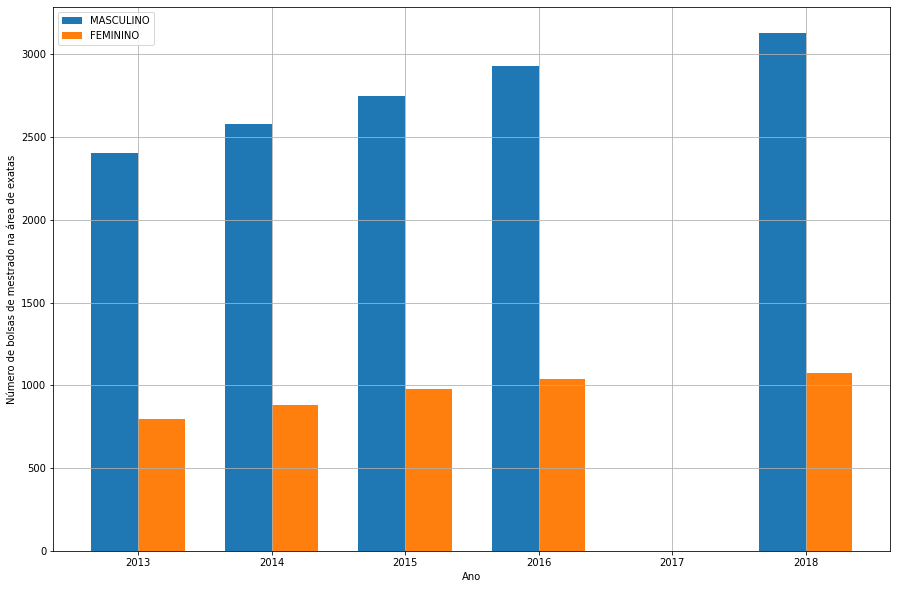

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15, 10))

width = 0.35
sexos = ['MASCULINO', 'FEMININO']

for sexo in sexos:
  df = df_docentes[((df_docentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'ENGENHARIAS')  
                     | (df_docentes['NM_GRANDE_AREA_CONHECIMENTO'] == 'CIÊNCIAS EXATAS E DA TERRA')) 
                     & (df_docentes['TP_SEXO_DOCENTE'] == sexo)
                     & (df_docentes['NM_GRAU_PROGRAMA'] == 'MESTRADO')]
  
  
  series = df.groupby('AN_BASE').AN_BASE.count()
  if sexo == 'MASCULINO':
    ax.bar(series.index - width/2, series, width,  label=sexo)
  else:
    ax.bar(series.index + width/2, series, width,  label=sexo)

#df

ax.grid(True)
ax.set_xlabel("Ano")
ax.set_ylabel("Número de bolsas de mestrado na área de exatas")
ax.legend(loc='best')
